In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

In [2]:
#load files to train model on

antelope_bloom = np.load('/home/esther/shared/2019-03-30_antelope.npy')
elsinore_bloom = np.load('/home/esther/shared/2019-03-25_elsinore.npy')
grassmtn_bloom = np.load('/home/esther/shared/2019-03-18_grassmtn.npy')

antelope_nobloom = np.load('/home/esther/shared/2019-03-10_antelope.npy')
elsinore_nobloom = np.load('/home/esther/shared/2019-04-24_elsinore.npy')
grassmtn_nobloom = np.load('/home/esther/shared/2019-04-27_grassmtn.npy')

In [3]:
#load label index arrays from intitial hand labelling
#update iteration as needed

antelope_bloom_labels = np.load('/home/esther/shared/2019-03-30_antelope_labels_iter1.npy')
elsinore_bloom_labels = np.load('/home/esther/shared/2019-03-25_elsinore_labels_iter1.npy')
grassmtn_bloom_labels = np.load('/home/esther/shared/2019-03-18_grassmtn_labels_iter1.npy')

antelope_nobloom_labels = np.load('/home/esther/shared/2019-03-10_antelope_labels_iter1.npy')
elsinore_nobloom_labels = np.load('/home/esther/shared/2019-04-24_elsinore_labels_iter1.npy')
grassmtn_nobloom_labels = np.load('/home/esther/shared/2019-04-27_grassmtn_labels_iter1.npy')

In [4]:
#pulls data from labelled pixels out of array and formats for input to model

def get_pixdata(idx_arr, img):
    
    #get row and column indices of labelled pixels
    idx_row_poppy, idx_col_poppy = np.nonzero(idx_arr==1)
    idx_row_nopoppy, idx_col_nopoppy = np.nonzero(idx_arr==0)

    #preallocate array to store pixel data
    pix_data_poppy = np.random.random((len(idx_row_poppy),13))
    pix_data_nopoppy = np.random.random((len(idx_row_nopoppy),13))

    #pull out all 13 channels for each poppy pixel and put into array
    for i, (row, col) in enumerate(zip(idx_row_poppy, idx_col_poppy)):
        pix_data_poppy[i, :] = img[row, col, :]
    
    #do same for no-poppy pixels
    for i, (row, col) in enumerate(zip(idx_row_nopoppy, idx_col_nopoppy)):
        pix_data_nopoppy[i, :] = img[row, col, :]
        
    return pix_data_poppy, pix_data_nopoppy

In [5]:
#predicts label of all pixels in an image

def predict_pixels_probas(img, scaler):
    
    #copy image array and reshape so channels are columns and pixels are rows
    img_copy = np.copy(img)
    img_copy = np.reshape(img_copy, (-1,13))
    
    #scale
    img_copy = scaler.transform(img_copy)
    
    #predict all the pixels and reshape for visualization
    preds = clf_rf.predict(img_copy)
    preds = np.reshape(preds, img[:,:,0].shape)
    
    #get prediction probability for all the pixels
    probas = clf_rf.predict_proba(img_copy)
    
    #reshape prediction that its a poppy - for visualization
    probas = np.reshape(probas[:,1], img[:,:,0].shape)
    
    return preds, probas

In [6]:
#plots visual check of predictions

def visual_check(preds, probas, img):
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    axs[0].imshow(preds)
    axs[1].imshow(np.minimum(img[:, :, [3,2,1]] * 5, 1))
    a = axs[2].imshow(probas)
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    axs[0].title.set_text('Prediction')
    axs[2].title.set_text('Poppy probability')
    
    fig.colorbar(a,ax=axs[2])

In [7]:
#look at pixels with predictions between specified probability values

def plot_thresh(probas, thresh1, thresh2, img, coords=''):
    
    if coords=='':
        y1 = 0
        x1 = 0
        y2 = img.shape[0]
        x2 = img.shape[1]
    else:
        y1,y2,x1,x2 = coords
    
    fix, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

    #threshold prediction probabilities
    probas_thresh = np.copy(probas)
    probas_thresh[probas_thresh < thresh1] = 0
    probas_thresh[probas_thresh > thresh2] = 0
    probas_thresh[probas_thresh > 0] = 1
    
    axs[0].imshow(probas_thresh[y1:y2, x1:x2])
    axs[1].imshow(np.minimum(img[y1:y2, x1:x2, [3,2,1]] * 5, 1))

    axs[0].grid()
    axs[1].grid()
    
    return probas_thresh

In [8]:
def get_neg(idx_arr, n):
    
    #get index values for each pixel
    idx = [index for index in np.ndindex(idx_arr.shape)]
    
    #randomly shuffle order and select the top n indices
    rng = np.random.default_rng(seed=1)
    rng.shuffle(idx)
    idx = idx[0:n]
    
    #for each pixel selected update the label index array
    for i in idx:
        idx_arr[i] = 0
        
    return idx_arr

In [60]:
#get data from pixels labelled during previous iteration

#bloom images
antelope_bloom_pixdata_poppy, antelope_bloom_pixdata_nopoppy = get_pixdata(antelope_bloom_labels, antelope_bloom)
elsinore_bloom_pixdata_poppy, elsinore_bloom_pixdata_nopoppy = get_pixdata(elsinore_bloom_labels, elsinore_bloom)
grassmtn_bloom_pixdata_poppy, grassmtn_bloom_pixdata_nopoppy = get_pixdata(grassmtn_bloom_labels, grassmtn_bloom)

#no bloom images
antelope_nobloom_pixdata_poppy, antelope_nobloom_pixdata_nopoppy = get_pixdata(antelope_nobloom_labels, antelope_nobloom)
elsinore_nobloom_pixdata_poppy, elsinore_nobloom_pixdata_nopoppy = get_pixdata(elsinore_nobloom_labels, elsinore_nobloom)
grassmtn_nobloom_pixdata_poppy, grassmtn_nobloom_pixdata_nopoppy = get_pixdata(grassmtn_nobloom_labels, grassmtn_nobloom)

#concatenate all poppy pixels and all no-poppy pixels
poppy_pixdata = np.vstack((antelope_bloom_pixdata_poppy, elsinore_bloom_pixdata_poppy, grassmtn_bloom_pixdata_poppy))
nopoppy_pixdata = np.vstack((antelope_bloom_pixdata_nopoppy, elsinore_bloom_pixdata_nopoppy, grassmtn_bloom_pixdata_nopoppy, \
                             antelope_nobloom_pixdata_nopoppy, elsinore_nobloom_pixdata_nopoppy, grassmtn_nobloom_pixdata_nopoppy))

In [61]:
#sanity check
print(poppy_pixdata.shape)
print(nopoppy_pixdata.shape)

(109269, 13)
(358607, 13)


In [62]:
#get features and labels
X = np.vstack((poppy_pixdata, nopoppy_pixdata))
y = np.concatenate( ( np.ones(poppy_pixdata.shape[0]), np.zeros(nopoppy_pixdata.shape[0]) ) )

In [63]:
#test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [64]:
#fit scaler to training data and scale
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

#apply same transformation to test data
X_test = scaler.transform(X_test)

In [65]:
#initialize model and fit to training data
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
clf_rf = clf_rf.fit(X_train, y_train);

In [66]:
#look at mean precision score
score_rf = clf_rf.score(X_test, y_test)
print(score_rf)

0.9962062922116782


In [67]:
#predict test data
y_pred_rf = clf_rf.predict(X_test)

In [68]:
#precision, recall and f-scores for each model, each class
prf_rf = precision_recall_fscore_support(y_test, y_pred_rf, average=None)
print(prf_rf)

(array([0.9952652 , 0.99935053]), array([0.99980472, 0.98441713]), array([0.9975298 , 0.99182762]), array([71693, 21883]))


# Save scaler and model

In [69]:
#save the scaler
pickle.dump(scaler, open('/home/esther/shared/scaler_iter3.pkl', 'wb'))

#save the model
pickle.dump(clf_rf, open('/home/esther/shared/model_iter3.pkl', 'wb'))

# Evaluate predictions on unlabelled pixels
### These visualizations are to help me select areas to hand label for this iteration

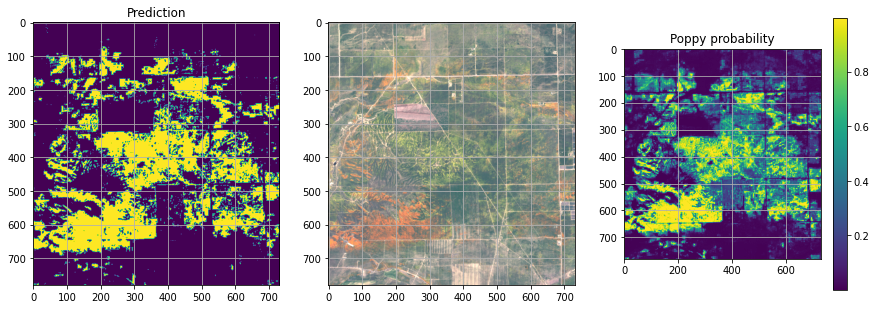

In [70]:
#antelope positive
antelope_bloom_preds, antelope_bloom_probas = predict_pixels_probas(antelope_bloom, scaler)
visual_check(antelope_bloom_preds, antelope_bloom_probas, antelope_bloom)

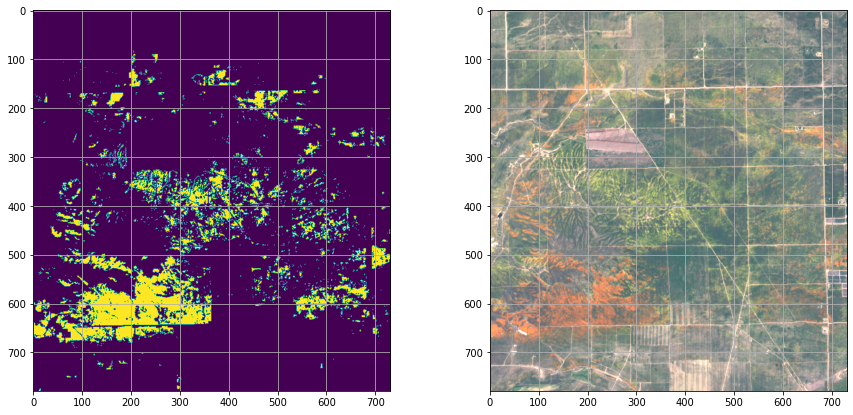

In [75]:
#look at definitely positive pixels
plot_thresh(antelope_bloom_probas, 0.9, 1, antelope_bloom);

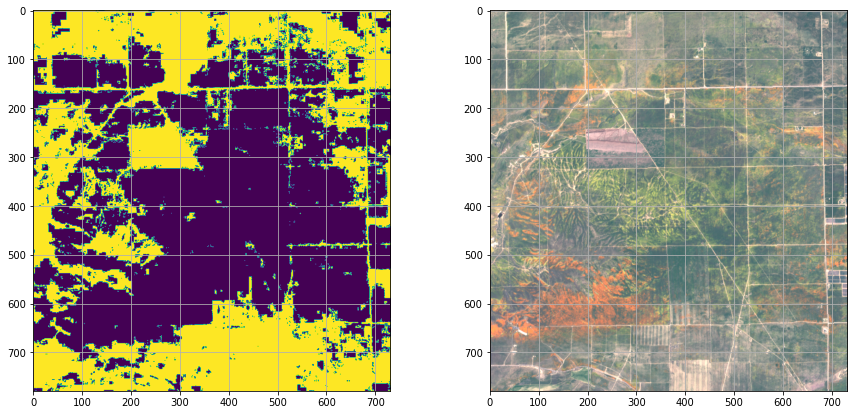

In [76]:
#look at pixels where the predictions are unsure
plot_thresh(antelope_bloom_probas, 0, 0.1, antelope_bloom);

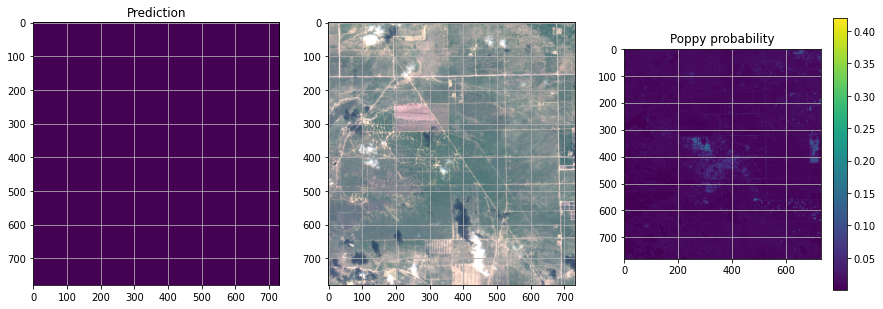

In [25]:
#antelope negative
antelope_nobloom_preds, antelope_nobloom_probas = predict_pixels_probas(antelope_nobloom, scaler)
visual_check(antelope_nobloom_preds, antelope_nobloom_probas, antelope_nobloom)

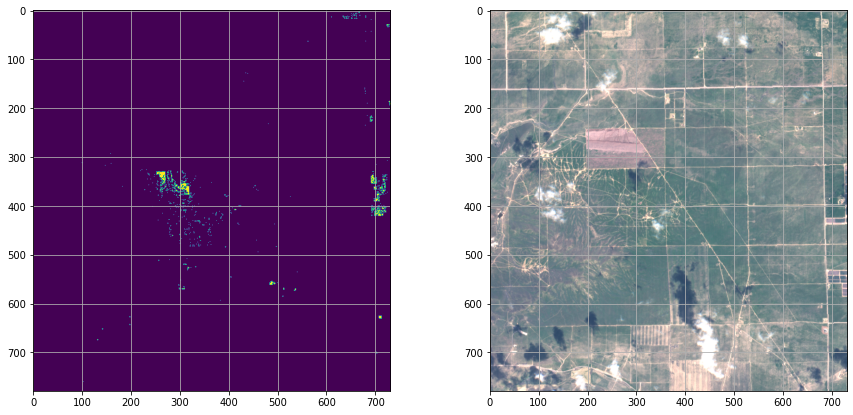

In [30]:
#look at pixels where the predictions are unsure
plot_thresh(antelope_nobloom_probas, 0.1, 0.2, antelope_nobloom);

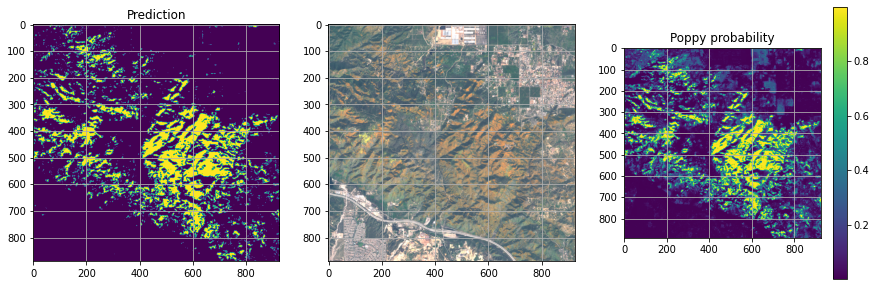

In [77]:
#elsinore positive
elsinore_bloom_preds, elsinore_bloom_probas = predict_pixels_probas(elsinore_bloom, scaler)
visual_check(elsinore_bloom_preds, elsinore_bloom_probas, elsinore_bloom)

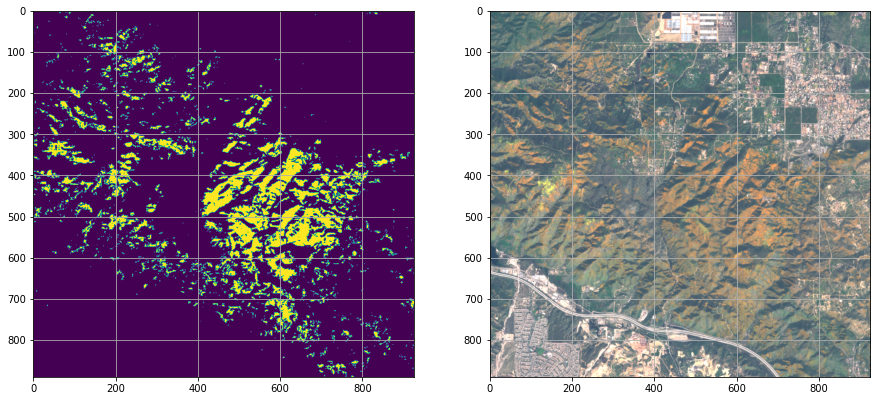

In [78]:
#look at definitely positive pixels
plot_thresh(elsinore_bloom_probas, 0.85, 1, elsinore_bloom);

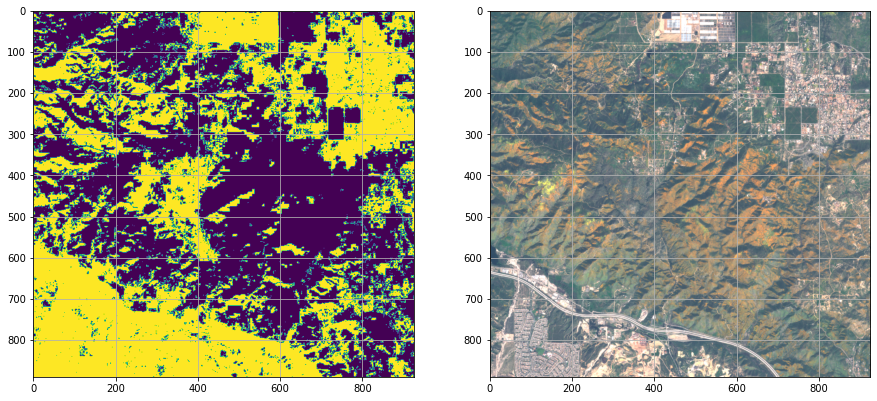

In [42]:
plot_thresh(elsinore_bloom_probas, 0, 0.05, elsinore_bloom);

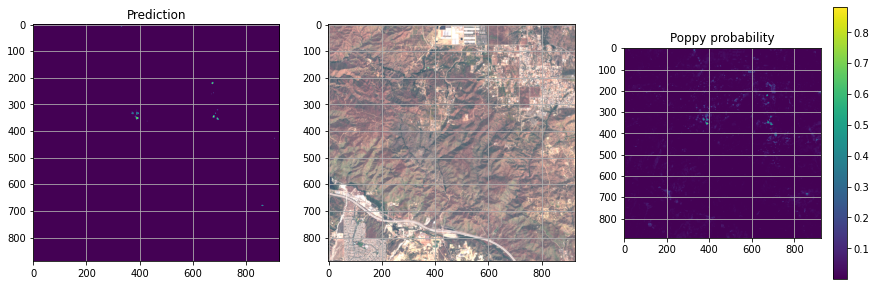

In [48]:
#elsinore negative
elsinore_nobloom_preds, elsinore_nobloom_probas = predict_pixels_probas(elsinore_nobloom, scaler)
visual_check(elsinore_nobloom_preds, elsinore_nobloom_probas, elsinore_nobloom)

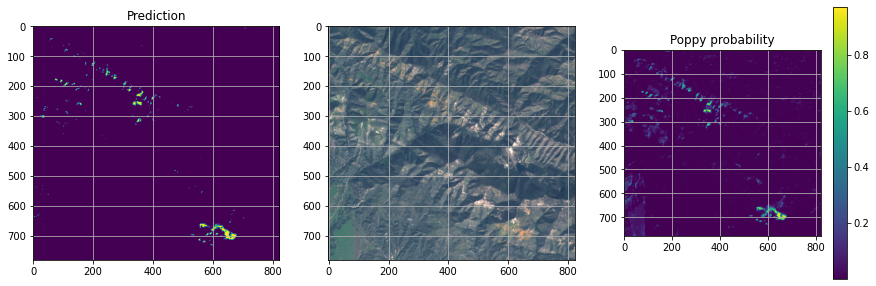

In [79]:
#grassmtn positive
grassmtn_bloom_preds, grassmtn_bloom_probas = predict_pixels_probas(grassmtn_bloom, scaler)
visual_check(grassmtn_bloom_preds, grassmtn_bloom_probas, grassmtn_bloom)

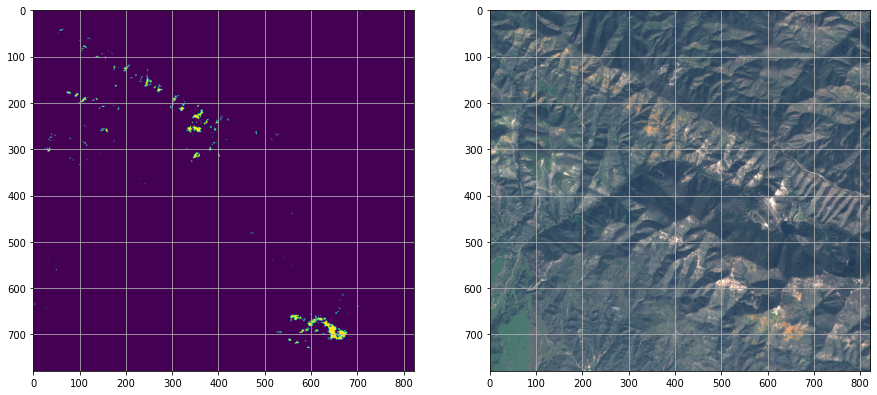

In [54]:
#look at thresholded probabilities
plot_thresh(grassmtn_bloom_probas, 0.5, 1, grassmtn_bloom);

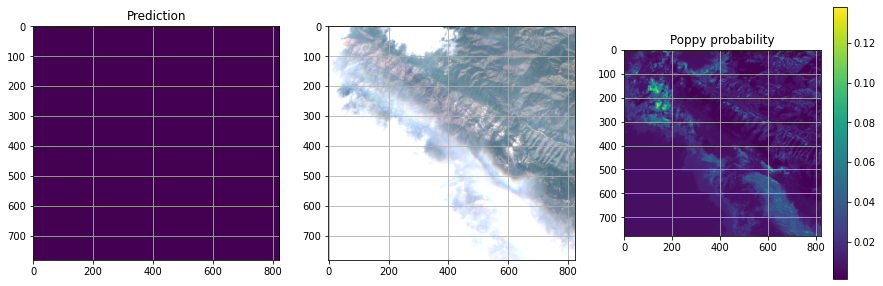

In [55]:
#grassmtn negative
grassmtn_nobloom_preds, grassmtn_nobloom_probas = predict_pixels_probas(grassmtn_nobloom, scaler)
visual_check(grassmtn_nobloom_preds, grassmtn_nobloom_probas, grassmtn_nobloom)

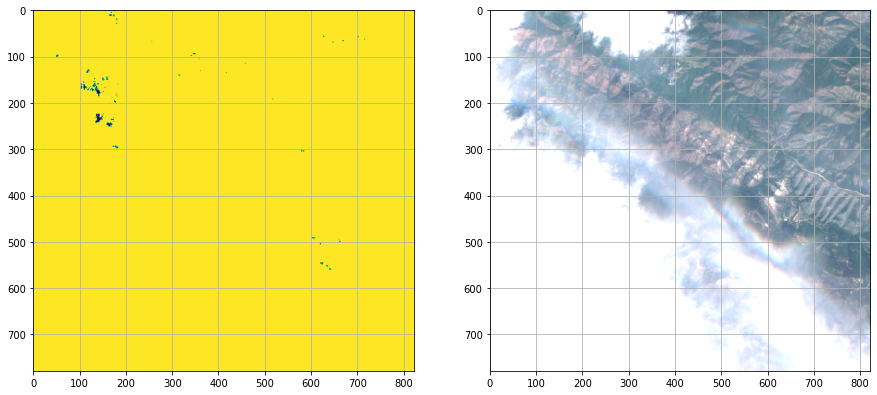

In [57]:
#look at thresholded probabilities
plot_thresh(grassmtn_nobloom_probas, 0, 0.1, grassmtn_nobloom);

# Update labels based on evaluations - ITERATION 1

In [ ]:
#update bloom labels

antelope_bloom_labels[0:60,355:400] = 0
antelope_bloom_labels[243:251,642:680] = 1
antelope_bloom_labels[antelope_bloom_probas>0.99] = 1

elsinore_bloom_labels[elsinore_bloom_probas>0.99] = 1

grassmtn_bloom_labels[700:750,0:100] = 0
grassmtn_bloom_labels[grassmtn_bloom_probas>0.7] = 1


#update no-bloom labels

#get number of pixels labelled as poppy
n_antelope = np.count_nonzero(~np.isnan(antelope_bloom_labels))
n_elsinore = np.count_nonzero(~np.isnan(elsinore_bloom_labels))
n_grassmtn = np.count_nonzero(~np.isnan(grassmtn_bloom_labels))

#generate Boolean array of randomly labelled pixels from no-poppy image
#get 3 times the number of positives
antelope_nobloom_labels = get_neg(antelope_nobloom_labels, n_antelope*3)
elsinore_nobloom_labels = get_neg(elsinore_nobloom_labels, n_elsinore*3)
grassmtn_nobloom_labels = get_neg(grassmtn_nobloom_labels, n_grassmtn*3)

# Update labels based on evaluations - ITERATION 2

In [58]:
#update bloom labels

antelope_bloom_labels[antelope_bloom_probas>0.95] = 1
elsinore_bloom_labels[elsinore_bloom_probas>0.85] = 1
grassmtn_bloom_labels[grassmtn_bloom_probas>0.5] = 1


#update no-bloom labels

#get number of pixels labelled as poppy
n_antelope = np.count_nonzero(~np.isnan(antelope_bloom_labels))
n_elsinore = np.count_nonzero(~np.isnan(elsinore_bloom_labels))
n_grassmtn = np.count_nonzero(~np.isnan(grassmtn_bloom_labels))

#generate Boolean array of randomly labelled pixels from no-poppy image
#get 3 times the number of positives
antelope_nobloom_labels = get_neg(antelope_nobloom_labels, n_antelope*3)
elsinore_nobloom_labels = get_neg(elsinore_nobloom_labels, n_elsinore*3)
grassmtn_nobloom_labels = get_neg(grassmtn_nobloom_labels, n_grassmtn*3)

# Save the updated label index arrays
### These arrays keep track of which pixels have been labelled, and what their label is

In [59]:
np.save('/home/esther/shared/2019-03-30_antelope_labels_iter2.npy', antelope_bloom_labels)
np.save('/home/esther/shared/2019-03-10_antelope_labels_iter2.npy', antelope_nobloom_labels)
np.save('/home/esther/shared/2019-03-25_elsinore_labels_iter2.npy', elsinore_bloom_labels)
np.save('/home/esther/shared/2019-04-24_elsinore_labels_iter2.npy', elsinore_nobloom_labels)
np.save('/home/esther/shared/2019-03-18_grassmtn_labels_iter2.npy', grassmtn_bloom_labels)
np.save('/home/esther/shared/2019-04-27_grassmtn_labels_iter2.npy', grassmtn_nobloom_labels)

In [ ]:
# #for demo3

# preds = antelope_pos_preds
# probas = antelope_pos_probas
# img = antelope_pos

# fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(4,16))
    
# axs[1].imshow(preds[470:700,0:340])
# axs[0].imshow(np.minimum(img[470:700,0:340, [3,2,1]] * 5, 1))
# #axs[2].imshow(probas[400:700,0:340])

# #threshold prediction probabilities
# probas_thresh = np.copy(probas)
# thresh = 0.99
# probas_thresh[probas_thresh < thresh] = 0
# probas_thresh[probas_thresh >= thresh] = 1

# axs[2].imshow(probas_thresh[470:700,0:340])

# axs[0].set_xticks([])
# axs[1].set_xticks([])
# #axs[2].set_xticks([])
# axs[2].set_xticks([])

# axs[0].set_yticks([])
# axs[1].set_yticks([])
# #axs[2].set_yticks([])
# axs[2].set_yticks([])

# fs = 20
# #axs[1].set_title('Predicted poppies', fontsize=fs)
# #axs[2].set_title('Prediction probability', fontsize=fs)
# #axs[2].set_title('Thresholded', fontsize=fs)